In [2]:
# Imports

# General imports
import pandas as pd
import numpy as np
import re

# Graphic libraries
import matplotlib.pyplot as plt
import plotly.express   as px
import seaborn as sns
import plotly.graph_objects as go

# Data preparation
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, AgglomerativeClustering

# Cluster Metrics.
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Dendogram for hierachy clustering.
from scipy.cluster.hierarchy import dendrogram, linkage

# Feature extraction.
from sklearn.decomposition import PCA

# Feature Selection.
from sklearn.feature_selection import RFECV

# Deactivating warnings of chanied assignation
pd.options.mode.chained_assignment = None

In [3]:
# Paths 
file_path = './data/'
file_name = 'dataset_desafio.csv'

## Loading data, quick analysis.

I need to get a better understanding of what each field on the given dataset represents. 

Based on Google search, and the quick analysis i do below, the meanings i can give to these columns are:

* 'song_name', 'artist', 'album', 'duration_ms', 'artist_genres', 'artist_popularity', 'artist_folowers', and 'release_year' = The names of these columns are pretty specific.
* 'danceability' = Means how danceable a song is, the bigger the value the more danceable a song is.
* 'energy' = In music is usually used in relation to sound power. The high pich values have high frequencies and thus they represent high energy states. Also a bigger value indicates more energetic a song is.
* 'loudness' = Amount of intensity a sound wave has, it is measured in decibel units. (dB). The bigger the value the louder.
* 'mode' = Mode or modus its most commonly use may be described as a type of musical scale coupled with a set of characteristics melodic and harmonic behaviors. It is applied to major and minor keys. So Major would be represented by 1 and minor is 0. (<a href='https://en.wikipedia.org/wiki/Mode_(music)'>Link about mode</a>)
* 'key' = This field is related to the previous one and its a categorical field that each value represents a pitch. In set theory, an integer notation is used, wich assigns a number between 0 and 11 to each pitch class 0 = C, 1 = C#, 2 = D, and so on.(<a href="https://open.library.okstate.edu/musictheory/chapter/pitch-and-pitch-class/#:~:text=Pitch%20classes%20are%20given%20an,tone%20with%20an%20individual%20frequency.&text=A%20system%20of%20naming%20pitch,%2C%20D%20as%202%2C%20etc.">Link about pitch</a>)
* 'speechiness' = Detects the presence of spoken words in a track. A Value near 0 means that the song most likely has little voice singing.
* 'acousticness' = How a acustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
* 'instrumentalness' = How likely the music contains no spoken word vocals. So the closer to 1.0 the more instrumental the song is.
* 'liveness' = Presence of a live audience in song, a bigger value might indicate that the song was recorded live.
* 'valence' =  Describes if the song is likely to make someone feel happy or sad, higher values might be asociated to more happyness.
* 'tempo' = Is the speed of pace of a given song, its meassured in Beats Per Minute (BPM), the bigger the value then the more beats per minute it has.

* 'mode' and 'key' = I can't interpret the meaning of these fields so I'll try to figure them out in EDA.


In [4]:
data = pd.read_csv(file_path+file_name)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   song_name          291 non-null    object 
 1   artist             291 non-null    object 
 2   album              291 non-null    object 
 3   danceability       291 non-null    float64
 4   energy             291 non-null    float64
 5   key                291 non-null    int64  
 6   loudness           291 non-null    float64
 7   mode               291 non-null    int64  
 8   speechiness        291 non-null    float64
 9   acousticness       291 non-null    float64
 10  instrumentalness   291 non-null    float64
 11  liveness           291 non-null    float64
 12  valence            291 non-null    float64
 13  tempo              291 non-null    float64
 14  duration_ms        291 non-null    int64  
 15  song_popularity    291 non-null    int64  
 16  artist_genres      291 non

In [5]:
# Lets pull out some statistics related to the data. Ill select the fields that I consider provide more information. 
# 1st of all im going to separate bewteen categorical columns and numerical column, in orther to facilitate Data Exploration.
mask_num_cols = (data.dtypes != 'object')
data_num_cols = data[data.dtypes.index[mask_num_cols]]
data_cat_cols = data[data.dtypes.index[~mask_num_cols]]

In [6]:
data_num_cols.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,2.910000e+02,291.000000
mean,0.577519,0.664526,5.402062,-8.009598,0.487973,0.064844,0.320144,0.074815,0.215163,0.594482,120.306581,226859.237113,44.075601,54.838488,2.741029e+06,2002.192440
std,0.169332,0.219575,3.628412,3.394579,0.500716,0.052145,0.313434,0.217098,0.201732,0.253076,28.324863,70661.662009,25.216876,19.259517,6.953692e+06,14.362214
min,0.103000,0.157000,0.000000,-18.752000,0.000000,0.025000,0.000004,0.000000,0.026500,0.038200,44.370000,86893.000000,0.000000,0.000000,1.300000e+01,1961.000000
25%,0.451500,0.490500,2.000000,-10.224500,0.000000,0.035100,0.033400,0.000000,0.091050,0.399000,98.558500,180967.000000,26.000000,45.000000,4.238850e+04,1991.000000
50%,0.587000,0.701000,6.000000,-7.178000,0.000000,0.045300,0.202000,0.000029,0.135000,0.617000,120.099000,217560.000000,50.000000,59.000000,4.685670e+05,2004.000000
75%,0.710500,0.853500,9.000000,-5.578000,1.000000,0.067650,0.577500,0.002630,0.260000,0.822000,136.165000,266126.500000,63.000000,67.000000,1.868729e+06,2014.500000
max,0.949000,0.986000,11.000000,-1.657000,1.000000,0.435000,0.984000,0.942000,0.970000,0.973000,193.660000,622000.000000,98.000000,91.000000,6.057431e+07,2022.000000


We can see that there is a variation in the magnitude of the data.

Since im planning on implementing K-Means, and this algorithm is distance-based, this difference in magnitude can create problems. So later on im planning to bring all the variables to the same magnitude by standardizing the data.

Another thing we can observe here is that probably we are going to have outliers due to the difference between the mean, standard deviation, and max value. So ill be investigating on that also later on, wheter if we need to eliminate them or we can ignore them.

## Null and duplicate presence analysis.

In [7]:
# Looking at a sample of the Dataset i could see, that for many rows, the column 'artist_genres' is an empty list.
len(data[data['artist_genres'] == "['[]']"])

41

In [8]:
# I will procede an replace this empty list with Nan Values.
data['artist_genres'].replace("['[]']", np.NAN, inplace=True)
data.isnull().sum()

song_name             0
artist                0
album                 0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_ms           0
song_popularity       0
artist_genres        41
artist_popularity     0
artist_followers      0
release_year          0
dtype: int64

In [9]:
data.duplicated().sum()

0

We can observe that there is no presence of nulls or either duplicates in the given dataset, so no imputation is needed.

## Outliers

In [10]:
# Checking outliers on numerical cols.
for i in data_num_cols.columns:
    fig = px.box(data, x=i)
    fig.update_layout(height=250, width=750)
    fig.show()

Seeing the outliers values, and with a bit more undersanding of the values each field can take, I can say that these outliers are valid data. I strongly believe that they are legitimate values that represent important escenarios, removing them could disort the reality of the data, harm the analysis, and lead to a loss of important information.

## EDA

Lets do a Exploratory Data Analysis to get more insights from given data.

In [11]:
correlation_matrix = data.corr()
fig = px.imshow(correlation_matrix)
fig.update_layout(height=850, width=850)
fig.show()

C:\Users\juanb\AppData\Local\Temp\ipykernel_8644\2211360409.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



This correlation matrix indicates the linear relationship between each variable. Positive correlation means that when one variable increase its value, other tends to increase as well. Negative correlation, means that when one variable increases, other thends to decreace.

From the correlation matrix we can say that:
* We cannot observe a significant positive or negative correlation between the given data. Also there are no signs of multicollinearity between the variables,
* 'danceability' is highly correlated with 'valence' (how happy a song makes you feel).
* The more energetic a song is the less acoustic it is and it has more loudnes. 'energy' and 'acousticness' are poorly correlated. Meanwhile 'energy' and 'loudness' are highly correlated. 
* Song Popularity is correlated positively with the Artist popularity, which make sense.

Now lets see each variable distribution.

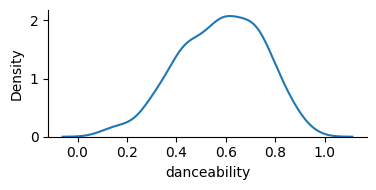

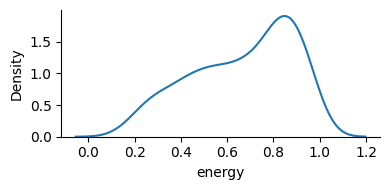

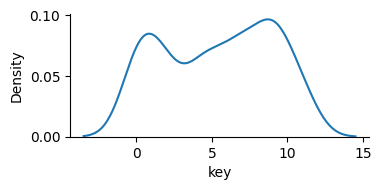

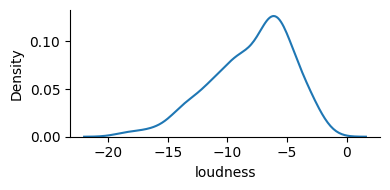

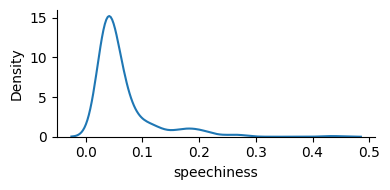

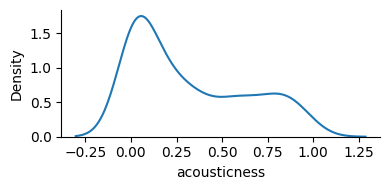

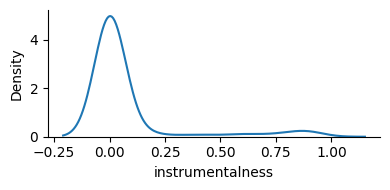

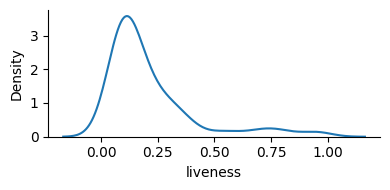

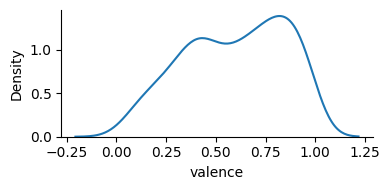

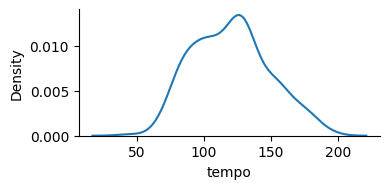

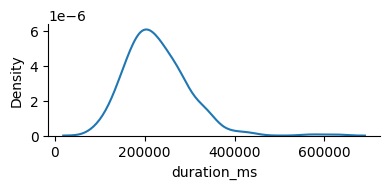

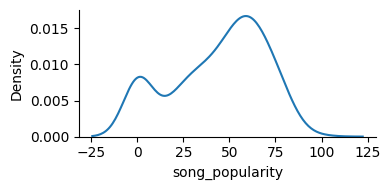

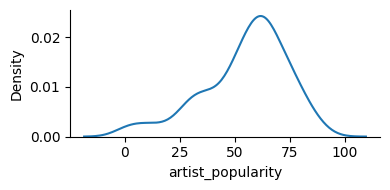

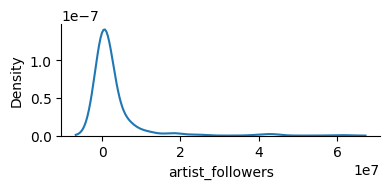

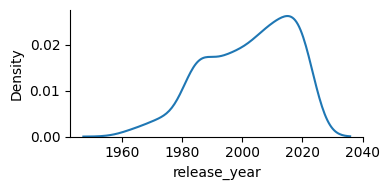

In [12]:
plot_cols = data_num_cols.columns.tolist()
plot_cols.remove('mode')
for i in plot_cols:
    sns.displot(data=data_num_cols, x=i, kind='kde',height=2, aspect=2)
    plt.show()

From this graphs we can see that each variable has different range of data, so we need to scale our dataset.

###  Artist with Most Songs

In [13]:
data_artist_amount_songs = data['artist'].value_counts().reset_index().sort_values('artist',ascending=False)[0:10]

# Changing names for interpretation.
data_artist_amount_songs.rename(columns={'index':'artist', 'artist' : 'total_amount_songs'}, inplace=True)

fig = px.bar(data_artist_amount_songs, x='artist', y='total_amount_songs')
fig.update_layout(height=500, width=550)
fig.show()

Artist with most songs is "Patricio Rey y sus Redonditos de Ricota" 

### Top 5 Artists.

In [14]:
# Grouping by artist, and obtaning its mean popularity, i use mean because i know that each artist has a unique popularity.
data_artist_grouped = data.groupby('artist', as_index=False)['artist_popularity'].mean()
# Now ill sort artis_popularity in descending form in order to keep only the most popular ones.
data_artist_grouped = data_artist_grouped.sort_values('artist_popularity', ascending=False).iloc[0:5]

fig = px.bar(data_artist_grouped, x='artist', y='artist_popularity')
fig.update_layout(height=350, width=500)
fig.show()

Lets see if the popular artists also hace the most popular songs.

In [15]:
# Grouping by artist, and obtaning its mean song popularity, in order to consider all artist songs and obtian a average song popularity value.
data_artist_grouped = data.groupby('artist', as_index=False)['song_popularity'].mean()
# Now ill sort artis_popularity in descending form in order to keep only the most popular ones.
data_artist_grouped = data_artist_grouped.sort_values('song_popularity', ascending=False).iloc[0:5]

fig = px.bar(data_artist_grouped, x='artist', y='song_popularity')
fig.update_layout(height=350, width=500)
fig.show()

Here we can see that out of the top 5 artist, 3 have the most popular songs (David Guetta, Eminem, and Shawn Mendes)

### Genres.

First im going to see what is the artist genres that appear the most.

In [67]:
# Creating DF with no null on 'artist_genres'.
data_artist_genre = data[['artist_genres']].dropna(how='any').reset_index(drop=True)

# Empty list to append all genres
list_artist_genre = []

# Iterating over each row.
for index in range(len(data_artist_genre)):
    # i've observed that the column 'genres' has a list passed as values, so ill split into idividual values.
    # Obtaning all artist genres on the list of values.
    row_artist_genres = data_artist_genre.iloc[index]['artist_genres'].split(',')
    
    for genre in row_artist_genres:
        # Apending each genre to my created list.
        list_artist_genre.append(genre)


data_artist_genre = pd.DataFrame(list_artist_genre, columns=['artist_genres'])

# Removing '[' and ']'.
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace('[','', regex=False)
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace(']','', regex=False)

# Removing ', character.
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace("'",'', regex=False)

# Remove leading spaces from the 'column_name'
data_artist_genre['artist_genres'] = data_artist_genre['artist_genres'].str.replace(r'^\s*', '', regex=True)

# Slecting the first 10 genres.
data_artist_genre_grouped = data_artist_genre.value_counts().sort_values(ascending=False).reset_index()[0:10]


# Renaming column, to give more sense.
data_artist_genre_grouped.rename(columns={0 : 'total_count'}, inplace=True)

fig = px.bar(data_artist_genre_grouped, x='artist_genres', y='total_count',title='Most common genres')
fig.update_layout(height=350, width=750)
fig.show()

Now im going to see the most popular genres. But i will keep the first value of the list of values, in order to see how the song popularity mean is for each artist genre.

In [24]:
# Using regex to retrieve the first element on the list of values.
# Creatting pattern.
pattern = "('+\w+(-*\s*\w*)*'+)"
# Compiling it.
pattern_re = re.compile(pattern)

# This function will be applied with .apply(lambda) it will return the 1st 
# element that match the given pattern.
def extract_artist_genre (text):
    patter_search = pattern_re.search(text)
    
    return patter_search.group(1) if patter_search else ''

In [68]:
# Creating a copy.
data_genre_popularity = data[['artist_genres', 'song_popularity']].dropna(how='any', axis=0).copy()

# Obtaining the 1st genre of list of values.
data_genre_popularity['artist_genres'] = data_genre_popularity['artist_genres'].apply(lambda x: extract_artist_genre(str(x)))

# Grouping by genre and calculating song popularity mean.
data_genre_popularity_grouped = data_genre_popularity.groupby('artist_genres')['song_popularity'].mean().reset_index()

# Sorting data and keeping the 1st 10 rows.
data_genre_popularity_grouped = data_genre_popularity_grouped.sort_values('song_popularity', ascending=False)[0:10]

fig = px.bar(data_genre_popularity_grouped, x='artist_genres', y='song_popularity',title='Most popular genres')
fig.update_layout(height=350, width=750)
fig.show()

Here we can see which are the most listened artist genres, "rock" get the most number of reproductions.

### Amount of song released each year.

In [16]:
df_song_release_per_year = data.groupby('release_year')['song_name'].count().reset_index().sort_values('song_name',ascending=False)

fig = px.bar(df_song_release_per_year, x='release_year', y='song_name')
fig.update_layout(height=350, width=750)
fig.show()

The year in which the most songs were released was 2012, 5.5% of total songs in the dataset.

### Distribution of Audio Features along the years

In [17]:
cols_plot = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

data_groupesd_per_year = data.groupby('release_year')[cols_plot].mean().reset_index()

for i in cols_plot:
    
    fig = px.line(data_groupesd_per_year, x='release_year', y=i)
    fig.update_layout(height=350, width=750)
    fig.show()



From this plots i can get good information:
* The danceability of the songs tended to increase over time. And suffered less variation after the 2000.
* Energy in the songs was less variable between the 2000 and the 2010.
* Loudness has its lowest peak in 1964 and 1968 after that it suffered a great increase in its values.
* Speechiness is constant along all considered years. Except in 1979, when it experienced a peak.
* Acousticness tended to decreace.
* In all fields (except instrumentaless), the highest peak occurs around 1980, after that year the values tend to present less diference between the peaks.

## Data Wrangling

So know that i've made an EDA and have a bit more understanding of data im working with, its time to prepare so that it can be consumed by the model.

The first this im going to do is to select my features or input variables.
In this case the data that will be useful to me is represented by the numerical fields.

The 'artist'genres' is an useful field. But, it has null presence, and too many genres in one list of values, so it isnt a reliable field to use. 
I could imputate those values based on the mean of the Audio feature for each genre, but i believe that it wont make much sense, so ill just ignore this field.

NOTE: i wont be maping and one-hot encoding the 'key' field instead im treating this variable as a labeled encoded, because this is an ordinal variable. Mode its already one-hot encoded.

In [18]:
feature_cols = data_num_cols.columns.to_list()
X = data[feature_cols]
X.sample(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
191,0.354,0.689,0,-5.133,1,0.0326,0.0145,0.000000,0.0847,0.139,147.539,330400,21,32,8453,2010
19,0.441,0.901,5,-8.640,1,0.0442,0.1580,0.004830,0.1320,0.786,183.322,156307,52,59,257766,1981
58,0.686,0.586,6,-12.377,1,0.0356,0.1530,0.000314,0.3530,0.780,120.418,224547,53,70,2120085,2010


Standarizing data in order to have the same scale along all my fields. This is neccesary because Clustering algorithms are based on distance.

In [19]:
# Its always good to keep a copie of the DF before applying any transformation to the data.
X_sc = X.copy()

In [20]:
# Bringing all variables to the same magnitude.
# Standard Scaler instance.
sc = StandardScaler()
# Fitting StandardScaler and adjusting magnitudes.
X_sc[feature_cols] = sc.fit_transform(X[feature_cols])

X_sc.sample(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,song_popularity,artist_popularity,artist_followers,release_year
3,0.618081,-0.162072,-0.387078,-0.746118,1.024351,1.213253,0.565223,-0.345079,1.046935,0.401826,-1.469704,-1.005473,-0.042728,-0.199647,-0.370457,0.893290
68,1.582342,-0.590909,0.993309,1.526702,-0.976228,0.462130,-0.425523,-0.343936,-0.383158,-0.049407,-0.531210,-1.260264,-1.194732,-2.696214,-0.394858,0.684049
133,1.032181,-2.037094,1.545464,-2.115063,-0.976228,0.008767,-1.021416,3.290743,-0.721316,-0.168152,0.345217,-0.655786,0.553137,-0.355682,-0.389475,-0.152916


## Clustering

Now im going to excecute a first cluster algorithm, and see how it performs, later on im going to compare it with other algorithm.

Before i start clustering i need to have a clear idea of what i want to achieve. Depending on my goal i will cluster based on different asspects of my data. 

The first thing i want to do is to see if i can find patterns in the data, for that im going to use all my variables. 

I will start using K-Means and compare this algorthm agains other two. the one that results the winner i will use it to see if i can define a goal.

Then based on my knowledge in the data ill try to select some fields to see if i can cluster and determine a pattern, and improve model performance.

In [21]:
# Stablishing a random_state.
rand_state  = 10

In [22]:
def select_number_of_cluster (df_feature, max_num_of_clusters=14, use_kmedoids = False):
    '''
        This function is used to evaluate Kmeans, and indicate how many clusters should be used. 
        By using the elbow rule.
        
        The input of this function are:
            - df_features = Features to train kmeans model.
            - max_num_of_cluster = Int, its used to determine the max number of cluster to consider.
            - use_kmedoids = if this is enabled the algorithm to use will be KMedoids.
            
        The Output will be:
            - Three plots = one for each metric (inertia, silhouse, calinski)
                from here we can select the optimum cluster value.
    '''
    df_feature = df_feature.copy()
    
    # List to store all inertia values.
    inertia_scores_list = []
    # List to store all silhouett scores.
    silhouse_scores_list = []
    # List to store all calinski scores.
    calinski_scores_list = []
    # List to store number of cluser.
    cluster_list = []
    
    for k in range(2,max_num_of_clusters):
        # Instancing and traning the kmeans or kmedoids algorithms.
        
        if use_kmedoids:
            model = KMedoids(n_clusters=k, random_state=rand_state)
        
        else:
            model = KMeans(n_clusters=k, random_state=rand_state)
            
        model.fit_predict(df_feature)
        
        # Obtaning an appending scores:
        #   Inertia.
        inertia_scr = model.inertia_
        inertia_scores_list.append(inertia_scr)
        
        #   silhouett.
        silhouette_scr = silhouette_score(df_feature, model.labels_)
        silhouse_scores_list.append(silhouette_scr)

        #   calinski.
        calinski_scr = calinski_harabasz_score(df_feature, model.labels_)
        calinski_scores_list.append(calinski_scr)
        
        # Storing k.
        cluster_list.append(k)
    
    df_scores =  pd.DataFrame()
    df_scores['number_cluster'] = cluster_list
    df_scores['inertia'] = inertia_scores_list
    df_scores['silhouette'] = silhouse_scores_list
    df_scores['calinski'] = calinski_scores_list
    
    plot_cols = ['inertia', 'silhouette', 'calinski']
    
    for i in plot_cols:
        fig = px.line(
            df_scores, 
            x='number_cluster', 
            y=i, 
            title='Number of cluster variation %s' %(i)
        )
        fig.update_layout(height=350, width=500)
        fig.show()

In [23]:
select_number_of_cluster(X_sc,max_num_of_clusters=15)

ill be using the elbow rule on the inertia graph and the silhouette graph, because calinski graph doesnt have a well defined peak.

Based on the 1st graph an using the elbow rule, i can say that an optimum number of clusters is k=8.

Using the 2nd graph and the Average Silhouette Method, seeing which clusters maximize the average silhoutte the optimum values are k=2 or k=5.

Ill use k = 8.

Now lets apply K-mean to our data to create clusters.

In [24]:
# Initializing the class object.
kmeans = KMeans(n_clusters=8, random_state=rand_state)

# Fitting model to data.
kmeans.fit(X_sc)

# Obtaning labels of clusters.
label = kmeans.labels_

## Vizualize generated clusters

To visualize the generated clusters, we will first need to reduce the data to two dimensions, using PCA. So we can plot it on a scatter plot.

Ill create a function to apply PCA, print useful information and plot the results obtained this.

Then ill evaulate cluster based on the following metrics:
* Silhouetter Score - Measures how well separated clusters are. This score ranges from -1 to 1, where higher values indicate better-defined clusters. One thing to have in mind, i found it on <a href='https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html'>Sklean web page</a> is that a value near +1 indicates that the sample point is far from the neighbouring cluster, as this value tends to lower the sample point tends to be nearer to a neighbour cluster, a NEGATIVE value indicates that the sample might have been assigned to the wrong cluster.
* Davied-Bouldin Index - Measures the average similarity between each cluster and its most similar cluster. Penalizes clusters that are not well-separeted. Lower values indicate better clustering.
* Calinski Index: Calculates the ratio between the external distance (inter-cluster) and the internal distance (intra-cluster  ). Higher values indicate better defined clusters.

In [25]:
def cluster_insights (df_features, labels, print_info=True, return_pca_df = True, return_cluster_plot=True):
    '''
        This function takes:
            - df_features =  dataframe that was used to train clusters.
            - labels = labels that was assigned to each row of the Feature DataFrame.
        It returns:
            - Dataframe with PCA applied, this is a DF with reduced dimensions, and with each 
                cluster class assosiated to it.
            - Plots in which to visualize the generated clusters.
            - Printed information about labels, and its balance, and different metrics to compare.
            
        So this functions is used to generate insights about a clustered DF. First it will apply PCA
        to reduce dimensionality, i do this because the difference between clusters will be easier to see.
        
        After the dimensionality reduction the clusters will be ploted, one plot is to visualize all clusters,
        and then there will be a plot for every cluster class there is, diferentiatin a given cluster from the 
        other clusters.
        
        Then if 'print_info' is enabled, the function will print usefull information like:
            - Number of elements on a given cluster, and the proportion that the cluster takes in the given sample.
            - silhouette score.
            - calinski idnex.
            - david-bouldin index.
        
        This function can return (if 'return_pca_df' is enabled) the PCA reduced dataframe with the two dimension
        as columns and a third colum that contain the cluster classes.
    '''
    df_features = df_features.copy()


    # --- REDUCING DIMENSIONALITY ---
    
    # Initializing a PCA model with 2 components.
    pca = PCA(n_components=2)
    # Reducing data to two dimensions using PCA model.
    features_2d = pca.fit_transform(df_features)
    
    # Creating DF
    df_features_2d = pd.DataFrame(data=features_2d, columns=['0','1'])
    # Apending clusters.
    df_features_2d['cluster'] = labels



    # --- PRINTING USEFUL INFORMATION ---
    
    # Geting the unique cluster assignments.
    unique_clusters = df_features_2d['cluster'].sort_values().unique()
    
    # If this condition is True from the input then the function will print the next information. 
    if print_info:
        print('#'*50+'\n')
        # Counting amount of clusters, also sorting values based on the number of cluster
        # so the number of cluster goes from 0, 1, 2, ..., n
        list_cluster_size = df_features_2d['cluster'].value_counts(normalize=False).sort_index()
        
        # Normalizing so i can get the proportion of each cluster.
        list_cluster_size_norm = df_features_2d['cluster'].value_counts(normalize=True).sort_index()
        
        # Iterating over clusters.
        for clstr in unique_clusters:
            # Obtaining the amount of assigments for the cluster that is currently being iterated.
            clstr_size = list_cluster_size[clstr]
            clstr_size_norm = round(list_cluster_size_norm[clstr],2)
            
            print(f'Cluster {clstr} - has {clstr_size} assignments ({clstr_size_norm}% of given the sample)')
        
        # Now im going to obtain different scores, so i can evaluate the clusters created.
        silh_score = round(silhouette_score(df_features, labels),2)
        davies_score = round(davies_bouldin_score(df_features, labels),2)
        calinsk_score = round(calinski_harabasz_score(df_features, labels),2)
        
        print('\n')
        print (f'Silhouette Score - {silh_score}')
        print (f'Davies-Boulding Index - {davies_score}')
        print (f'Calinski-Harabasz Index - {calinsk_score}')
        
        print('\n'+'#'*50+'\n')



    # --- PLOTING CLUSTERS ---
    
    # If this condition is true then the function will plot all cluster related graphs.
    if return_cluster_plot:
        # setting the dimensions of the plot
        fig, ax = plt.subplots(figsize=(4, 4))
        
        sns.scatterplot(df_features_2d, x='0', y='1', hue='cluster', style='cluster', palette='deep')
        plt.title('Generated Clusters')
        plt.grid(False)
        plt.axis('off')
        plt.show()
        
        # Iterate over the clusters.
        for clstr in unique_clusters:
            # Creating a copy of the features Df, so i can create a column to separate between the considered cluster and the not considered.
            plot_cluster = df_features_2d.copy()
            
            # Selecting data points that belong to current cluster.
            cluster_rows = df_features_2d['cluster'] == clstr
            plot_cluster.loc[cluster_rows,'hue_cluster'] = '0'
            
            # Selecting data that belongs to the other clusters.
            other_cluster_rows = df_features_2d['cluster'] != clstr
            plot_cluster.loc[other_cluster_rows, 'hue_cluster'] = '1'
            
            # Reordering Df so it show 1st the number of cluster.
            plot_cluster = plot_cluster.sort_values('hue_cluster')
            
            # setting the dimensions of the plot
            fig, ax = plt.subplots(figsize=(2, 2))
            color_palette = ['#08090D', '#B3B8C8']
            sns.set_palette(color_palette)
            sns.scatterplot(plot_cluster, x='0', y='1', hue='hue_cluster', size='hue_cluster', sizes=(20,50))
            plt.title(f'Cluster {clstr}')
            plt.legend().set_visible(False)
            plt.grid(False)
            plt.axis('off')
            plt.show()




    # --- RETURNING PCA DF ---
    
    # If this condition is True from the input then the used df will be returned.
    if return_pca_df:
        return df_features_2d

Ill define another function that will plot the cluster characteristics, a good way of interpreting the cluster is to investigate the averges of features for every cluster. 

In [26]:
def cluster_characteristics(df_features, labels, return_characteristics_df=True):
    '''
        As the above function, the inputs are:
            - df_featues = DF that was used to train cluster.
            - labels = Generated labels by cluster model.
            
        This function will return a plot in which we can see how the mean of each cluster vary for each feature.
        Also it can return a Df with the mean of each feature for each cluster.
    '''
    df_features = df_features.copy()
    
    # First im going to create a column with cluster assignments.
    df_features['cluster'] = labels
    
    # Grouping data by cluster and computing the mean.
    cluster_mean = df_features.groupby('cluster').mean().reset_index()
    
    # Ploting.
    fig = px.bar(cluster_mean, x='cluster', y=cluster_mean.columns[1:], title='Cluster Characteristics',barmode='group')
    fig.show()
    
    if return_characteristics_df:
        return cluster_mean

##################################################

Cluster 0 - has 10 assignments (0.03% of given the sample)
Cluster 1 - has 85 assignments (0.29% of given the sample)
Cluster 2 - has 52 assignments (0.18% of given the sample)
Cluster 3 - has 44 assignments (0.15% of given the sample)
Cluster 4 - has 44 assignments (0.15% of given the sample)
Cluster 5 - has 17 assignments (0.06% of given the sample)
Cluster 6 - has 19 assignments (0.07% of given the sample)
Cluster 7 - has 20 assignments (0.07% of given the sample)


Silhouette Score - 0.11
Davies-Boulding Index - 1.92
Calinski-Harabasz Index - 28.2

##################################################



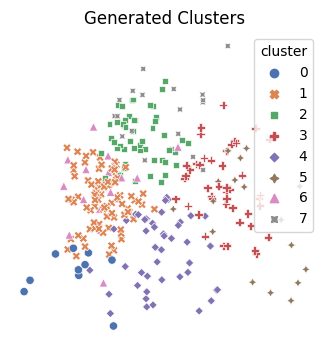

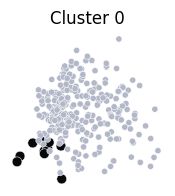

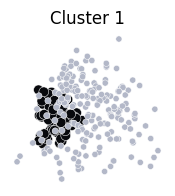

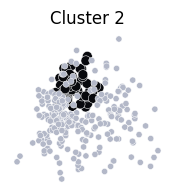

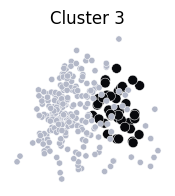

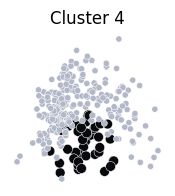

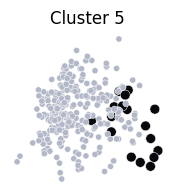

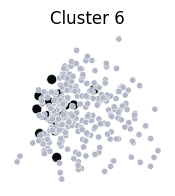

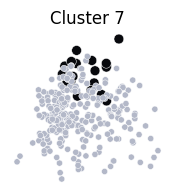

In [27]:
cluster_insights(X_sc, label, return_pca_df=False, print_info=True, return_cluster_plot=True)

In [28]:
cluster_characteristics(X_sc, label, return_characteristics_df=False)

### Conclusion about applying K-Means algorithm.


Based on the information i obtained, i can say that:
* Cluster 0: is grouping the songs that have high amount of artist followers, artist popularity and it seems that a high son popularity also fits in this cluster, so i can say that this cluster is can be grouping songs that tend to be more popular.
* Cluster 1: Was the one with most assigments, based on the characteristics on this group we can see that the songs in this goup doesnt have high values in all features.
* Cluster 2: Grouping high values on danceability and valence, so this could indicate that this songs could be more lively of can be used in a dance club (maybe?).
* Cluster 3: Gathering the songs that have a higher acousticness, and low values of instrumentalness and speechiness. 
* Cluster 5: Gropuing songs that tend to have lower loudness values and the highest instrumentalness. Probably electro music.
* Cluster 6: Songs that are more energetic and have high liveliness tend to fall in this cluster.
* Cluster 7: Grouping songs that have a high speechiness value.


Regarding the quality of the results, i think they are not perfect but we can identify a good distinction between clusters. 

Regarding the metrics i obtained im going to compare them with another clustering model.

## K-Medoids

Ill use K-Medoids because this model is more robust to noises, because it uses actual data points as medoids. Each cluster is represented by a medoid, this is an acual data point within the cluster, and has the smallest sum of distances to all other points in the cluster.

In [29]:
select_number_of_cluster(X_sc,max_num_of_clusters=20,use_kmedoids=True)

Again using the elbow rule i get that the optimum number of cluster should be k=8.

In [30]:
# Initializing algorithm object
kmedoids = KMedoids(n_clusters=8, random_state=rand_state)

# Fitting model to data.
kmedoids.fit(X_sc)

# Obtaning labels of clusters.
label = kmedoids.labels_

##################################################

Cluster 0 - has 27 assignments (0.09% of given the sample)
Cluster 1 - has 38 assignments (0.13% of given the sample)
Cluster 2 - has 35 assignments (0.12% of given the sample)
Cluster 3 - has 32 assignments (0.11% of given the sample)
Cluster 4 - has 49 assignments (0.17% of given the sample)
Cluster 5 - has 50 assignments (0.17% of given the sample)
Cluster 6 - has 26 assignments (0.09% of given the sample)
Cluster 7 - has 34 assignments (0.12% of given the sample)


Silhouette Score - 0.01
Davies-Boulding Index - 2.96
Calinski-Harabasz Index - 13.51

##################################################



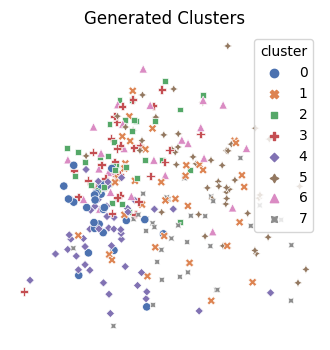

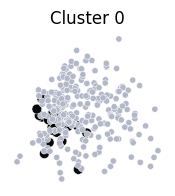

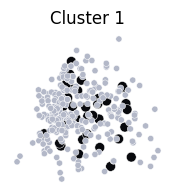

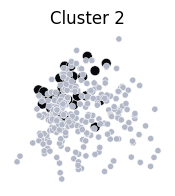

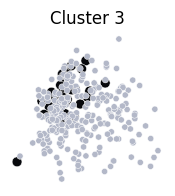

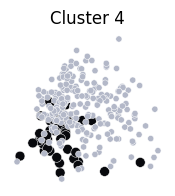

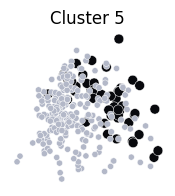

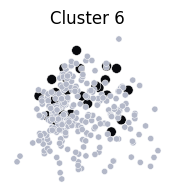

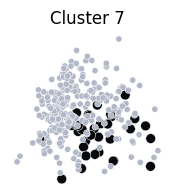

In [31]:
cluster_insights(X_sc, label, return_pca_df=False, print_info=True, return_cluster_plot=True)

In [32]:
cluster_characteristics(X_sc, label, return_characteristics_df=False)

### Conclusion about applying K-Medoids algorithm.

This algorithm performed worse than k-means, i say worse because i cant stablish a pattern on why the cluster where created this way.

I obtained a more balanced selection of songs but there are no marked differences between the diferent clusters, theres no need in going for a deeper analysis, just by looking at metrics i can say that this cluster performed poorly. K-Means performed better.

Yet i will try another algorithm to see if i can get to perform better than K-Means.

## Hierarchical clustering.

Ill use Agglomerative clustering, where each data point start as its own cluster, and pairs off successively merged based on a likage criteria until one cluster remains.

Ill use a dendogram to select the optimum number of clusters, ill look for the longest vertical distance and draw a horizontal line across that distance. the number of intersections of the horizontal line with the dendogram will give me the number of clusters.

Also ill use 'ward' linkage method becuase i have a really agglomerated data. The 'ward' linkeage method tends to work well when dealing with compact, spherical clusters.

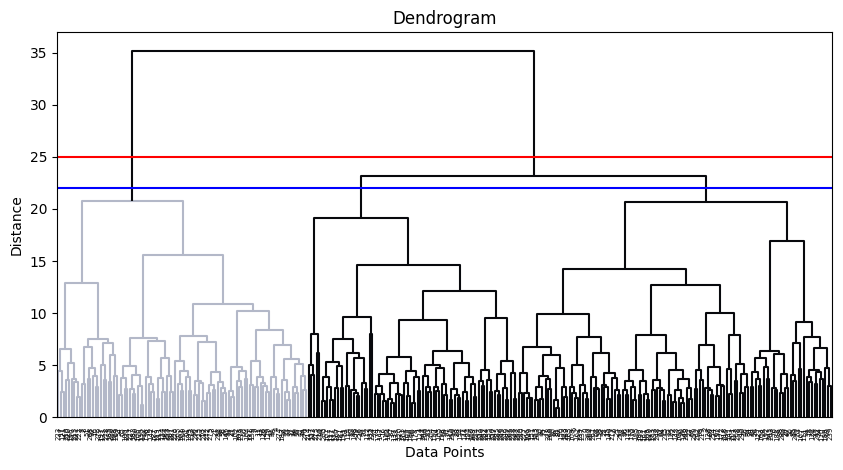

In [33]:
Z = linkage(X_sc, method='ward', metric='euclidean')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Dendrogram')
plt.axhline(y = 25, color = 'r', linestyle = '-')
plt.axhline(y = 22, color = 'b', linestyle = '-')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

From the dendogram i have two possible values of optimum clusters. k=2 or k=3. Ill select k=2, because it has the two longest verical distance.

Now that i've selected the amount of clusters im going to train my model.

In [34]:
agg_clust = AgglomerativeClustering(n_clusters=2,linkage='ward')

# Fitting model to data.
agg_clust.fit(X_sc)
label = agg_clust.labels_

##################################################

Cluster 0 - has 197 assignments (0.68% of given the sample)
Cluster 1 - has 94 assignments (0.32% of given the sample)


Silhouette Score - 0.14
Davies-Boulding Index - 2.3
Calinski-Harabasz Index - 44.34

##################################################



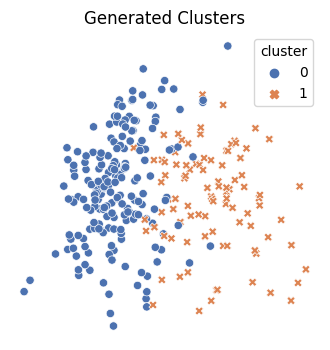

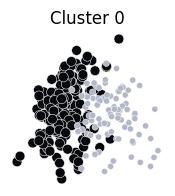

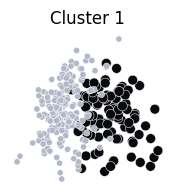

In [35]:
cluster_insights(X_sc, label, return_pca_df=False, print_info=True, return_cluster_plot=True)

In [36]:
cluster_characteristics(X_sc, label, return_characteristics_df=False)

Here we have two clusters, Cluster 1 seems to be assigned to songs that tend to have the highest and lowest values of features. While Cluster 0 tends to be assignated to songs that are not extreme like.

This cluster can be interpreted as a song recommender, it can recommend songs for specific taste (cluster 1) or for more general taste (cluster 0).

I've tried different number of clusters in this hierarchical clustering. But indeed the best result can be observed  with two clusters.

As for the metrics, if we compare them against the ones we obtained in K-means we can see that the ones obtained with agglomerative clustering seems to be better:
* Silhouette Score - 0.14 (Agglomerative) vs 0.11(K-Means). The difference here is not that great.
* Davies-Boulding Index - 2.3 vs 1.92. Here the one that obtained a lower value is K-Means, a lower value in this index indicates better clustering.
* Calinski-Harabasz - 44.34 vs 28.2. As for this difference, we can observe a lower value in K-Means, this is due to the fact that in K-means we uses a bigger amount of clusters (8), while for Agglomerative we just defined two clusters, so it make sense that the distance between centroid is bigger, if we would compare this metric with the same amount of clusters, then K-Means would perfom better than Agglomerative.

Because of all this im going to say that the best perfoming cluster algorithm is K-MEANS.

That being said im going to perform feature selection to select the best combination of variables and see if i can obtain better defined clusters.

## Feature Selection

This section is called Feature Selection but its not related to Feature selection in the way of selecting the most relevant features.

Here im going to stablish a goal, try to see if i can group similar artist genres based on the fields i consider to be useful.

I believe that useful columns are the ones that are referred to musical properties. Columns referred to its popularity, artist, duration, and release year are not useful.

In [37]:
# Columns to drop.
col_name_drop = ['duration_ms', 'song_popularity', 'artist_popularity', 'artist_followers', 'release_year', 'key' , 'mode']
X_sc.drop(columns=col_name_drop,inplace=True)
X_sc.head(2)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.617837,0.814217,1.291216,-0.386966,-0.208198,-0.342132,-0.259018,1.462619,-0.858412
1,-0.204204,1.357107,0.788670,0.790627,-0.935598,-0.220627,-0.621507,0.176210,2.594180


In [38]:
# Now im going to select the best amount of clusters.
select_number_of_cluster(X_sc,max_num_of_clusters=20)

In [39]:
# Initializing the class object.
kmeans = KMeans(n_clusters=12, random_state=rand_state)

# Fitting model to data.
kmeans.fit(X_sc)

# Obtaning labels of clusters.
label = kmeans.labels_

##################################################

Cluster 0 - has 29 assignments (0.1% of given the sample)
Cluster 1 - has 25 assignments (0.09% of given the sample)
Cluster 2 - has 41 assignments (0.14% of given the sample)
Cluster 3 - has 22 assignments (0.08% of given the sample)
Cluster 4 - has 8 assignments (0.03% of given the sample)
Cluster 5 - has 5 assignments (0.02% of given the sample)
Cluster 6 - has 42 assignments (0.14% of given the sample)
Cluster 7 - has 17 assignments (0.06% of given the sample)
Cluster 8 - has 8 assignments (0.03% of given the sample)
Cluster 9 - has 56 assignments (0.19% of given the sample)
Cluster 10 - has 9 assignments (0.03% of given the sample)
Cluster 11 - has 29 assignments (0.1% of given the sample)


Silhouette Score - 0.2
Davies-Boulding Index - 1.37
Calinski-Harabasz Index - 47.98

##################################################



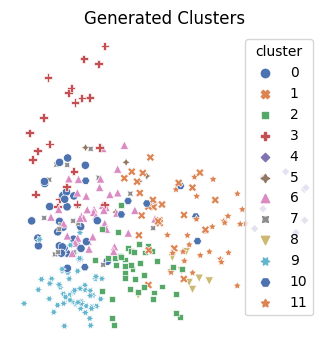

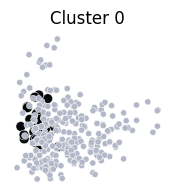

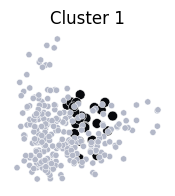

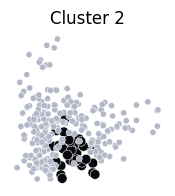

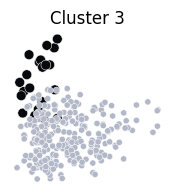

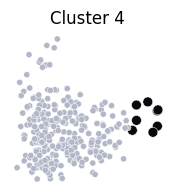

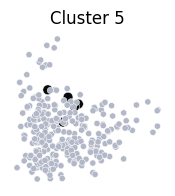

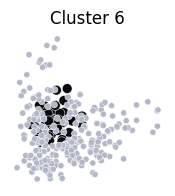

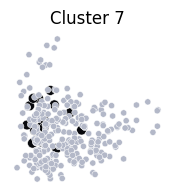

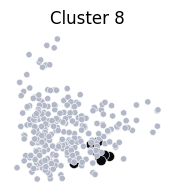

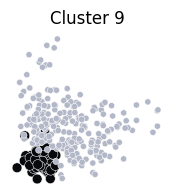

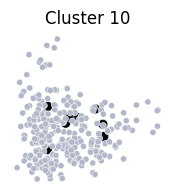

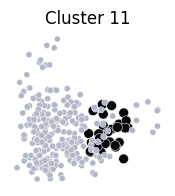

In [40]:
cluster_insights(X_sc, label, return_pca_df=False, print_info=True, return_cluster_plot=True)

In [41]:
cluster_characteristics(X_sc, label, return_characteristics_df=False)

If we pay close attention to the metrics we can see that we've obtained better metrics, this would indicate that the generated clusters are more optimum than the previous ones.

Let's see how the created clusters grouped the artist's genres.

In [42]:
# Using regex to retrieve the first element on the list of values.
# Creatting pattern.
pattern = "('+\w+(-*\s*\w*)*'+)"
# Compiling it.
pattern_re = re.compile(pattern)

# This function will be applied with .apply(lambda) it will return the 1st 
# element that match the given pattern.
def extract_artist_genre (text):
    patter_search = pattern_re.search(text)
    
    return patter_search.group(1) if patter_search else ''

In [43]:
# Creating a function to drop Nans of Artist Genres and to plot the
#   1st genre that appears in the list of values in this field.
def plot_artist_genres_cluser (labels):
    # Creating a copy so i can work fresh.
    data_genre = pd.DataFrame(data['artist_genres'].copy())
    data_genre['cluster'] = labels
    
    # Droping song that have empty lists of values = '[[]]'
    data_genre.dropna(how='any', axis=0, inplace=True)
    
    data_genre['artist_genres'] = data_genre['artist_genres'].apply(lambda x: extract_artist_genre(x))
    
    # Gruping clusters.
    data_genre_grouped = data_genre.groupby('cluster')['artist_genres'].value_counts().reset_index(name='count')
    
    # Iterating over each clusters, and plotting results.
    for i in data_genre_grouped['cluster'].unique():
        # Creating mask to consider the cluster in loop.
        df_plot_cluster = data_genre_grouped[data_genre_grouped['cluster'] == i]
        # Ploting so i can see how much values each cluster had.
        fig = px.bar(df_plot_cluster,x='artist_genres', title=f'Cluster {i}')
        fig.update_layout(
            yaxis=dict(title=None, showticklabels=False),
            xaxis=dict(tickwidth=2, tickfont=dict(size=17),title=None),
            #width=1250,
            height=300
        )
        fig.show()

In [44]:
plot_artist_genres_cluser(label)

Here we can see that the clusters grouped similar songs, like rock, or pop, for example Cluster 5, all the songs in this cluster have similar characteristics.

## Feature Extraction

The last step in this notebook will be to see if i can generate new variables from the ones that i've selected. Ill use Principal Component Analysis (PCA). This algorithm is used to reduce dimensionality of datasets. 

Since my dataset is uncorrelated i can apply this without problem.

PCA has many applications:
* dimensionality reduction.
* Noise removal.
* Generation of new features.

Ill create a function that will plot the explained ratio variance as a function of component numbers to be selected. 

PCA defines Principal Component as a linar combination of the original features. I will plot each principal componen sequentially, the 1st PC will explain the largest variance in data, the second PC explains the sencond-largest variance, and so on. They will be sorted in the order of the amount of variance they explain.

In [45]:
def feature_extraction_pca (df_features, return_pca_df=True):
    '''
        This function takes a DF of features already scaled and apply PCA to it.
        It will return, if enabled, 
            1 - the final DF (the one that PCA was apply to).
            2 - a plot in which we can see how the explained variance and the 
                accumulated variance ratio for each Principal Component.
    '''
    pca = PCA(random_state=rand_state)
    df_features_pca = pca.fit_transform(df_features)
    
    # Principal Components (PC) Amounts.
    cps = np.arange(1,pca.components_.shape[0] + 1)
    # Explained variance ratio of each PC.
    single_variance_ratio = pca.explained_variance_ratio_
    # Accumulated explained variance ratio.
    accumulated_variance_ratio = np.cumsum(single_variance_ratio)
    
    # Creating DF with PC and Explained Variance Ratio, single and Accumulated.
    data_plot = pd.DataFrame({'Single Variance' : single_variance_ratio, 'Accumulated Variance' : accumulated_variance_ratio}, index=cps)
    
    fig = go.Figure()
    # Adding Individual Variance.
    fig.add_trace(go.Scatter(x = data_plot.index, y = data_plot['Single Variance'], mode = 'lines+markers', name = 'Single Variance'))
    # Adding Accumulated Variance.
    fig.add_trace(go.Scatter(x = data_plot.index, y = data_plot['Accumulated Variance'], mode = 'lines+markers', name = 'Accumulated Variance'))
    
    fig.update_layout(height=650, width=1000, title = 'Explained Variance in function of PCs',
                    xaxis_title = 'PCs', yaxis_title = 'Explained Variance Percenage')
    fig.show()
    
    if return_pca_df:
        return pd.DataFrame(df_features_pca)

In [46]:
X_sc_pca = feature_extraction_pca(X_sc)

I'm going to use the elbow rule to obtain the amount of principal components to select. 

The point to be selected represents the optimal number of PCs, and is where we still retain enought information and reduce dimensionality. Also another common approach is to select the number of PCs that explain a significant amount of the total variance.

Having this in mind i belive that keeping 6 PC is the best, is where we explain almost 80% of variance and when the individual variance difference start to diminish.

In [47]:
# Keeping the selected PCs.
X_sc_pca = X_sc_pca.loc[:,0:4]

# Selecting the amount of clusters to group.
select_number_of_cluster(X_sc_pca,max_num_of_clusters=20)

##################################################

Cluster 0 - has 74 assignments (0.25% of given the sample)
Cluster 1 - has 20 assignments (0.07% of given the sample)
Cluster 2 - has 81 assignments (0.28% of given the sample)
Cluster 3 - has 8 assignments (0.03% of given the sample)
Cluster 4 - has 71 assignments (0.24% of given the sample)
Cluster 5 - has 22 assignments (0.08% of given the sample)
Cluster 6 - has 15 assignments (0.05% of given the sample)


Silhouette Score - 0.28
Davies-Boulding Index - 1.07
Calinski-Harabasz Index - 90.21

##################################################



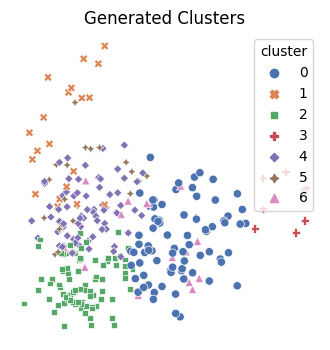

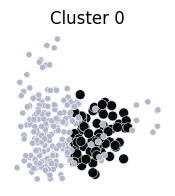

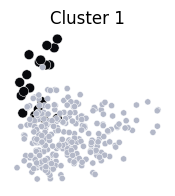

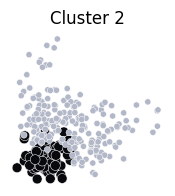

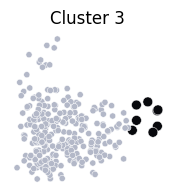

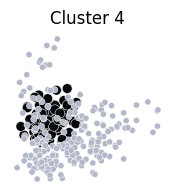

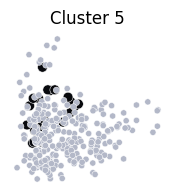

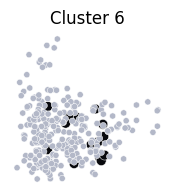

In [48]:
# Training my model.
kmeans = KMeans(n_clusters=7, random_state=rand_state)
kmeans.fit(X_sc_pca)

# Obtaining labels.
label = kmeans.labels_
cluster_insights(X_sc_pca, label, return_pca_df=False)

In [49]:
cluster_characteristics(X_sc, label, return_characteristics_df=False)

In [50]:
plot_artist_genres_cluser(label)

### Conclusions about PCA.

After appling PCA and evaluating the metrics i can say that this model was the best performing model.

Silhouette Score - 0.2  (no pca)  - 0.28 (with pca)

Davies-Boulding Index - 1.37  - 1.07 

Calinski-Harabasz Index - 47.98 - 90.21

All the metrics were improved.

We can see that for example:
* Cluster 1 has a high average value of liveness this cloud indicate that songs in this cluster are live songs.
* In cluster 3 songs with high instrumentalness and low danceability, energy, loudness, valence, and tempo are grouped, this are slow songs with a lot of instruments. If we see the grouped artist genres that are present in this cluster we can see that they fit in this caregory.
* If we see cluster 5, we can see high values of speechiness, and postivie values on every other metric except, instrumentalness. With use of instruments, vocals, rythm. Tango fits  good in this category. 
* in cluster 6 song with high instrumentalness are grouped, and if we see the artist genres that fit into this cluster we can see song genres that use more instruments than spoken words, like celtic, irish, or orquesta.

i also tried see if this cluster was grouping different artist, but i coundt reach to a good conclusion about if the cluster was grouping artist with similarities.

## Final conclusion

So to conclude and to give a closure, I made a deep analysis of the given data sample.

I was able to observe patterns and make comparisons of different clustering models, where it was proved that for the given sample the best performing model was K-Means with PCA. I applied PCA to reduce dimensionality and noise in data, and this brought good results.

We observed that i was able to discover some patterns in data, how the songs were grouped and compare the different genres of artist and discover than even the cluster is not the best, i was able to capture clusters with same characteristics.